# Hierarchical Forecasting with M4 Dataset

This notebook explains and demonstrates various approaches to hierarchical forecasting, as described in the reference document. We will use the M4 dataset, which contains hierarchical time series data.

## 1. Setup and Data Loading

First, let's install the necessary libraries. The reconciliation tools have been moved to the `hierarchicalforecast` library.

In [14]:
!pip install -q statsforecast hierarchicalforecast datasetsforecast matplotlib

In [15]:
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace
from datasetsforecast.m4 import M4
import matplotlib.pyplot as plt

### Load M4 Hourly Dataset and Define Hierarchy

We use the `datasetsforecast` library to download and load the data, which is more reliable than a direct URL. We then create a small, two-level hierarchy for demonstration.

In [16]:
# Download and load the M4 Hourly dataset
M4.download(directory=".", group="Hourly")
Y_df, *_ = M4.load(directory=".", group="Hourly")

Y_df["ds"] = pd.to_datetime(Y_df["ds"])

# Create a smaller sample for demonstration
bottom_series_names = Y_df["unique_id"].unique()[:10]
Y_bottom_df = Y_df[Y_df["unique_id"].isin(bottom_series_names)]

# Create the 'Total' series
Y_total_df = Y_bottom_df.groupby("ds")[["y"]].sum().reset_index()
Y_total_df["unique_id"] = "Total"

# Combine into a single dataframe for forecasting
Y_hat_df = pd.concat([Y_bottom_df, Y_total_df])

# Define the Summing Matrix (S)
s_df_list = []
s_df_list.append(
    pd.DataFrame({"unique_id": ["Total"], **{k: [1] for k in bottom_series_names}})
)
for name in bottom_series_names:
    s_df_list.append(
        pd.DataFrame(
            {
                "unique_id": [name],
                **{k: [1] if k == name else [0] for k in bottom_series_names},
            }
        )
    )
S_df = pd.concat(s_df_list).set_index("unique_id")

# Define tags for levels
tags = {"Total": np.array(["Total"]), "bottom": bottom_series_names}

## 2. Generate Base Forecasts

First, we generate independent forecasts for all series in the hierarchy using `StatsForecast`.

In [17]:
sf = StatsForecast(models=[AutoARIMA()], freq="H", n_jobs=-1)
base_forecasts = sf.forecast(df=Y_hat_df, h=24)

/home/huijo/miniconda3/envs/voids/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/huijo/miniconda3/envs/voids/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


## 3. Reconcile Forecasts

Now, we use `HierarchicalReconciliation` to apply different reconciliation methods to the base forecasts.

In [19]:
S_df.head()

,H1,H10,H100,H101,H102,H103,H104,H105,H106,H107
unique_id,,,,,,,,,,
Total,1,1,1,1,1,1,1,1,1,1
H1,1,0,0,0,0,0,0,0,0,0
H10,0,1,0,0,0,0,0,0,0,0
H100,0,0,1,0,0,0,0,0,0,0
H101,0,0,0,1,0,0,0,0,0,0


In [20]:
S_df.reset_index(inplace=True)

In [21]:
reconcilers = [
    BottomUp(),
    TopDown(method="forecast_proportions"),
    MinTrace(method="ols"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
reconciled_forecasts = hrec.reconcile(Y_hat_df=base_forecasts, S=S_df, tags=tags)

## 4. Visualize Results

Let's plot the 'Total' forecast from each method to compare them.

In [ ]:
reconciled_forecasts.head(5)

,unique_id,ds,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols
0,Total,1970-01-01 01:00:00.000000748,109116.523795,109252.248840,109116.523795,109128.862435
1,Total,1970-01-01 02:00:00.000000748,103371.502603,103792.381404,103371.502603,103409.764312
2,Total,1970-01-01 03:00:00.000000748,99053.572703,99739.064957,99053.572703,99115.890180
3,Total,1970-01-01 04:00:00.000000748,94687.049690,95858.337098,94687.049690,94793.530363
4,Total,1970-01-01 05:00:00.000000748,91688.107794,93208.557368,91688.107794,91826.330482
5,Total,1970-01-01 06:00:00.000000748,90360.526983,92040.074104,90360.526983,90513.213085
6,Total,1970-01-01 07:00:00.000000748,90443.130168,92122.155312,90443.130168,90595.768817
7,Total,1970-01-01 08:00:00.000000748,91337.507124,92926.762847,91337.507124,91481.984917
8,Total,1970-01-01 09:00:00.000000748,93300.736165,94562.577461,93300.736165,93415.449010
9,Total,1970-01-01 10:00:00.000000748,96118.021932,96880.629666,96118.021932,96187.349907


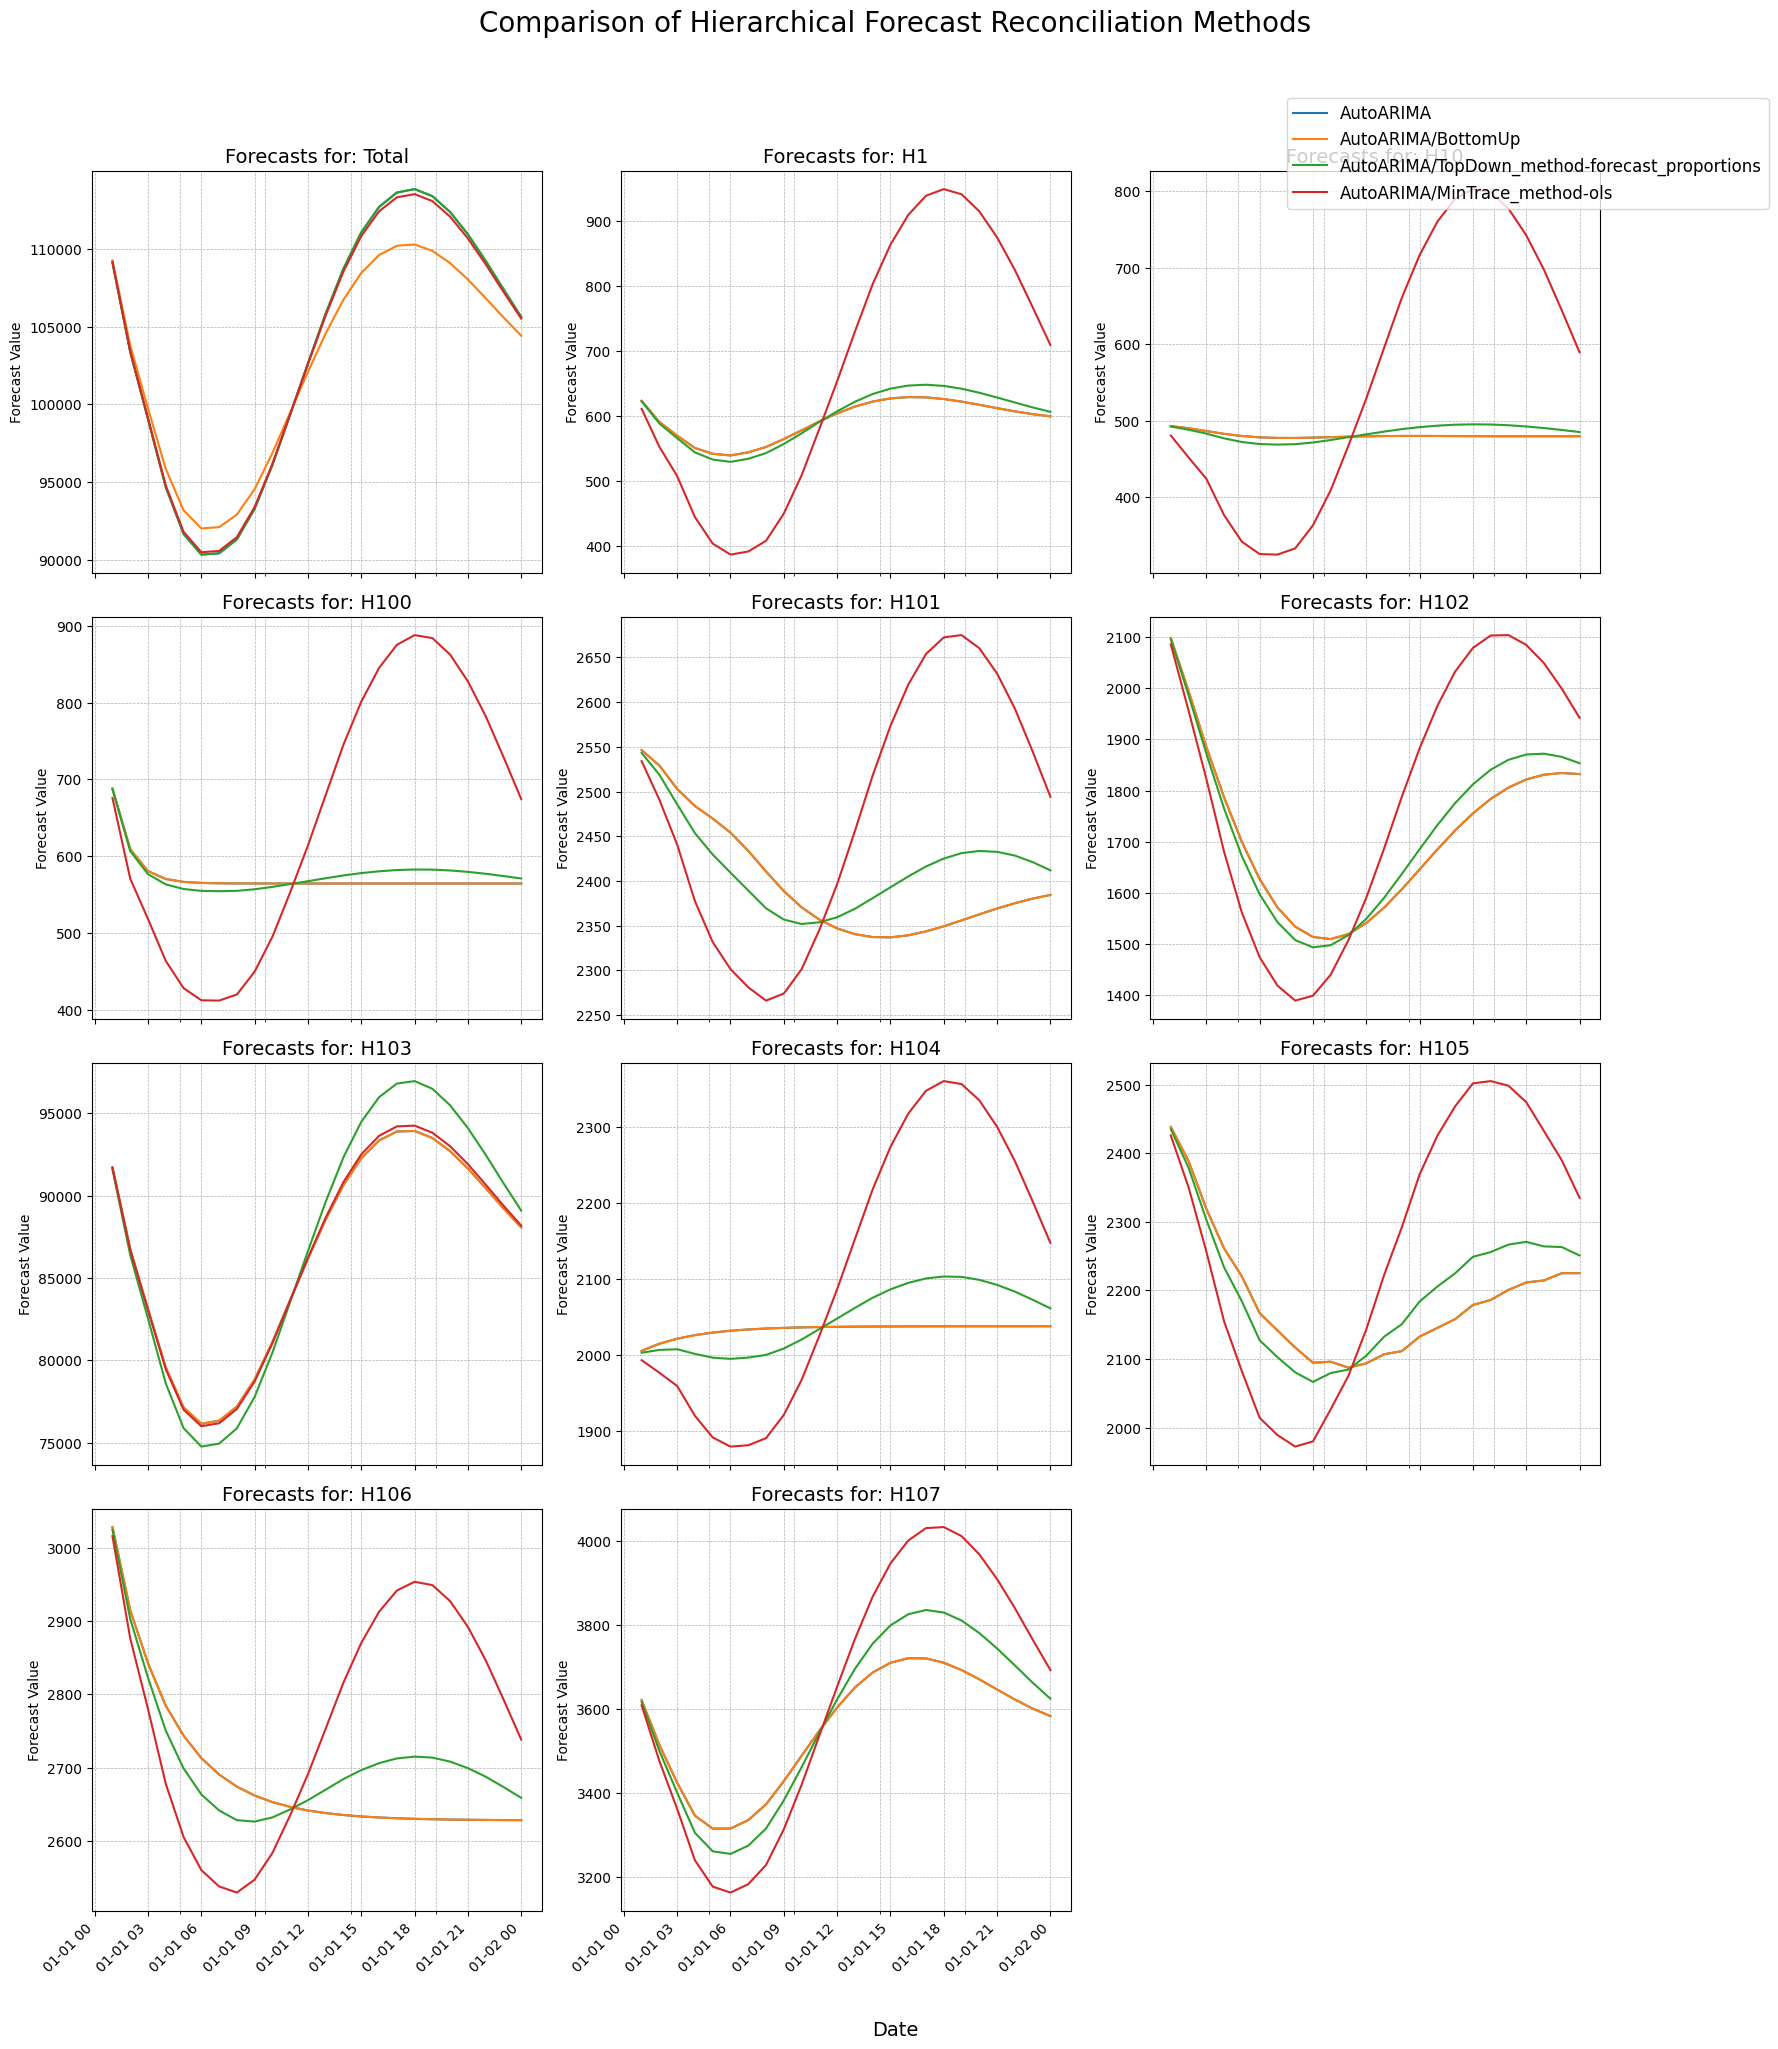

In [ ]:
# Convert 'ds' to datetime, but DO NOT set it as the index
reconciled_forecasts["ds"] = pd.to_datetime(reconciled_forecasts["ds"])

# If you already ran the old code and set the index, you can revert it with:
# reconciled_forecasts.reset_index(inplace=True)


# --- Plotting Setup ---
unique_ids = reconciled_forecasts["unique_id"].unique()
n_series = len(unique_ids)
n_cols = 3
n_rows = math.ceil(n_series / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), sharex=True)
axes = axes.flatten()

# --- Plotting Loop ---
for i, uid in enumerate(unique_ids):
    ax = axes[i]

    # Filter the DataFrame for the current unique_id
    df_plot = reconciled_forecasts[reconciled_forecasts["unique_id"] == uid]

    # Get the names of the forecast columns to plot (all columns except identifiers)
    forecast_cols = reconciled_forecasts.columns.drop(["unique_id", "ds"])

    # Explicitly define 'ds' as the x-axis and the forecast columns as the y-axis
    df_plot.plot(x="ds", y=forecast_cols, ax=ax, legend=False)

    # --- Formatting the Subplot ---
    ax.set_title(f"Forecasts for: {uid}", fontsize=14)
    ax.set_ylabel("Forecast Value")
    ax.set_xlabel("")  # Remove individual x-axis labels to avoid clutter
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.tick_params(axis="x", rotation=45)

# --- Final Figure Formatting ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.99, 0.98), fontsize=12)

# Hide any unused subplots
for i in range(n_series, len(axes)):
    axes[i].axis("off")

fig.suptitle(
    "Comparison of Hierarchical Forecast Reconciliation Methods", fontsize=20, y=1.02
)
fig.text(
    0.5, 0.01, "Date", ha="center", va="center", fontsize=14
)  # Add a single x-axis label for the figure
plt.tight_layout(rect=[0, 0.03, 0.9, 0.98])
plt.show()